# Predicting and Simulating Financial Market Regimes Using CGAN and LSTM

**Authors:** Riki Awal Syahputra, Darrus Loamayer, Yiyang Liu  
**Course:** COMP6784001 - Fundamentals of Data Science  
**Institution:** Binus International University

---


## Section 1: Setup & Imports



In [6]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [7]:
#!/usr/bin/env python3
"""
Complete Analysis Script for Financial Market Regime Prediction
CGAN + LSTM Hybrid Model

Run this script to execute the entire analysis pipeline.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
import json
import pickle

# Data acquisition
import yfinance as yf
try:
    from fredapi import Fred
    HAS_FRED_API = True
except:
    HAS_FRED_API = False
    
from pandas_datareader import data as pdr

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time series
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from scipy.spatial.distance import jensenshannon
from scipy.stats import probplot

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Utilities
from tqdm.auto import tqdm

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Create directories
Path('data/raw').mkdir(parents=True, exist_ok=True)
Path('data/processed').mkdir(parents=True, exist_ok=True)
Path('models').mkdir(parents=True, exist_ok=True)
Path('results/figures').mkdir(parents=True, exist_ok=True)
Path('results/metrics').mkdir(parents=True, exist_ok=True)

print("="*80)
print("FINANCIAL MARKET REGIME PREDICTION - CGAN + LSTM")
print("="*80)


Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
FINANCIAL MARKET REGIME PREDICTION - CGAN + LSTM


---
## Section 2: Data Acquisition



In [8]:
print("\n[1/11] DATA ACQUISITION")

START_DATE = '2010-01-01'
END_DATE = '2024-12-31'
FRED_API_KEY = "6471be419152257e21225e7de5e915c5"  # FRED API key

print(f"Fetching S&P 500 data ({START_DATE} to {END_DATE})...")
sp500 = yf.download('^GSPC', start=START_DATE, end=END_DATE, progress=False)
# Handle MultiIndex columns from yfinance
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.get_level_values(0)
sp500 = sp500[['Close']].rename(columns={'Close': 'SP500'})
sp500.index.name = 'Date'
sp500.to_csv('data/raw/sp500.csv', index=True)
print(f"[OK] S&P 500: {len(sp500)} observations")

print("Fetching FRED data (Fed Funds Rate, CPI)...")
try:
    if FRED_API_KEY and HAS_FRED_API:
        fred = Fred(api_key=FRED_API_KEY)
        fedfunds = fred.get_series('FEDFUNDS', observation_start=START_DATE, observation_end=END_DATE)
        cpi = fred.get_series('CPIAUCSL', observation_start=START_DATE, observation_end=END_DATE)
    else:
        fedfunds = pdr.DataReader('FEDFUNDS', 'fred', START_DATE, END_DATE).squeeze()
        cpi = pdr.DataReader('CPIAUCSL', 'fred', START_DATE, END_DATE).squeeze()
    
    fedfunds.index.name = 'Date'
    cpi.index.name = 'Date'
    fedfunds.to_csv('data/raw/fedfunds.csv', header=True)
    cpi.to_csv('data/raw/cpi.csv', header=True)
    print(f"[OK] Fed Funds Rate: {len(fedfunds)} observations")
    print(f"[OK] CPI: {len(cpi)} observations")
except Exception as e:
    print(f"Error fetching FRED data: {e}")
    print("Please check your internet connection or FRED API key")
    exit(1)



[1/11] DATA ACQUISITION
Fetching S&P 500 data (2010-01-01 to 2024-12-31)...
[OK] S&P 500: 3773 observations
Fetching FRED data (Fed Funds Rate, CPI)...
[OK] Fed Funds Rate: 180 observations
[OK] CPI: 180 observations


---
## Section 3: Data Preprocessing & Feature Engineering



In [9]:
print("\n[2/11] DATA PREPROCESSING & FEATURE ENGINEERING")

# Load data
sp500 = pd.read_csv('data/raw/sp500.csv', index_col=0, parse_dates=True)
fedfunds = pd.read_csv('data/raw/fedfunds.csv', index_col=0, parse_dates=True)
cpi = pd.read_csv('data/raw/cpi.csv', index_col=0, parse_dates=True)

# Ensure proper column names (convert Series to DataFrame if needed)
if isinstance(fedfunds, pd.Series):
    fedfunds = fedfunds.to_frame(name='FEDFUNDS')
elif 'FEDFUNDS' not in fedfunds.columns:
    fedfunds.columns = ['FEDFUNDS']
    
if isinstance(cpi, pd.Series):
    cpi = cpi.to_frame(name='CPI')
elif 'CPI' not in cpi.columns:
    cpi.columns = ['CPI']

# Merge datasets
df = sp500.copy()
fedfunds_daily = fedfunds.reindex(df.index).ffill()
cpi_daily = cpi.reindex(df.index).ffill()
df['FEDFUNDS'] = fedfunds_daily['FEDFUNDS']
df['CPI'] = cpi_daily['CPI']
df.dropna(inplace=True)

print(f"Combined dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Feature Engineering
print("Engineering features...")
df['returns'] = np.log(df['SP500'] / df['SP500'].shift(1))
df['volatility'] = df['returns'].rolling(window=30).std()
df['MA_50'] = df['SP500'].rolling(window=50).mean()
df['MA_200'] = df['SP500'].rolling(window=200).mean()
df['momentum'] = df['SP500'] - df['SP500'].shift(20)
df['price_to_MA50'] = df['SP500'] / df['MA_50']
df['price_to_MA200'] = df['SP500'] / df['MA_200']
df['inflation'] = df['CPI'].pct_change(periods=252)
df.dropna(inplace=True)

print(f"Features engineered. Shape: {df.shape}")

# Winsorization
print("Winsorizing outliers...")
for col in ['returns', 'volatility', 'momentum']:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

print("[OK] Preprocessing complete")



[2/11] DATA PREPROCESSING & FEATURE ENGINEERING
Combined dataset shape: (0, 3)
Date range: nan to nan
Engineering features...
Features engineered. Shape: (0, 11)
Winsorizing outliers...
[OK] Preprocessing complete


---
## Section 4: Regime Labeling




[3/11] REGIME LABELING
Regime distribution:
Series([], Name: count, dtype: int64)

Regime percentages:
Series([], Name: proportion, dtype: float64)


IndexError: index 0 is out of bounds for axis 0 with size 0

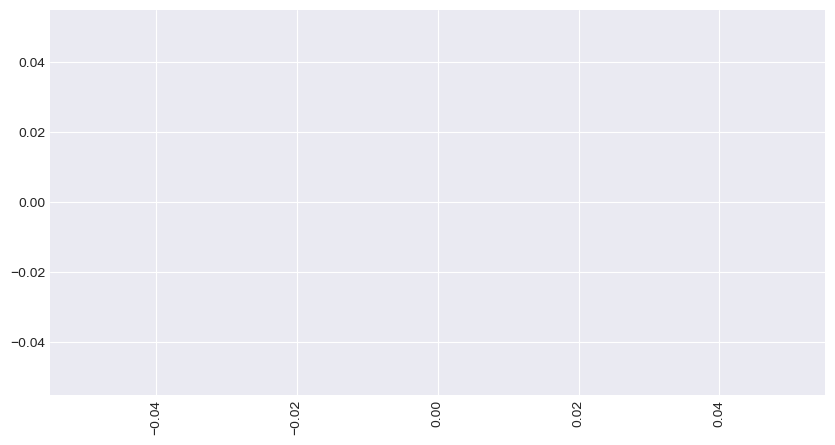

In [10]:
print("\n[3/11] REGIME LABELING")

def classify_regime(row, vol_threshold):
    if row['volatility'] < vol_threshold and row['momentum'] > 0:
        return 'bull'
    elif row['volatility'] >= vol_threshold and row['momentum'] < 0:
        return 'bear'
    else:
        return 'volatile'

vol_threshold = df['volatility'].median()
df['regime'] = df.apply(lambda row: classify_regime(row, vol_threshold), axis=1)

# Encode regimes
label_encoder = LabelEncoder()
df['regime_encoded'] = label_encoder.fit_transform(df['regime'])

with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Regime distribution:")
print(df['regime'].value_counts())
print(f"\nRegime percentages:")
print(df['regime'].value_counts(normalize=True) * 100)

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
df['regime'].value_counts().plot(kind='bar', ax=ax, color=['green', 'red', 'orange'])
ax.set_title('Market Regime Distribution (2010-2024)', fontsize=14, fontweight='bold')
ax.set_xlabel('Regime')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('results/figures/regime_distribution.png', dpi=300)
plt.close()

print("[OK] Regime labeling complete")


---
## Section 5: Exploratory Data Analysis



In [ ]:
print("\n[4/11] EXPLORATORY DATA ANALYSIS")

# Time series plot with regimes
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for regime, color in zip(['bull', 'bear', 'volatile'], ['green', 'red', 'orange']):
    mask = df['regime'] == regime
    axes[0].scatter(df[mask].index, df[mask]['SP500'], c=color, label=regime.capitalize(), alpha=0.5, s=1)
axes[0].set_ylabel('S&P 500 Price')
axes[0].set_title('S&P 500 with Market Regimes', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df['volatility'], color='purple', linewidth=0.8)
axes[1].set_ylabel('Volatility (30-day)')
axes[1].set_title('Rolling Volatility', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df.index, df['FEDFUNDS'], color='blue', linewidth=0.8)
axes[2].set_ylabel('Fed Funds Rate (%)')
axes[2].set_xlabel('Date')
axes[2].set_title('Federal Funds Rate', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/eda_timeseries.png', dpi=300)
plt.close()

# Correlation matrix
features_for_corr = ['returns', 'volatility', 'momentum', 'FEDFUNDS', 'inflation', 'price_to_MA50']
corr_matrix = df[features_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/figures/correlation_matrix.png', dpi=300)
plt.close()

# Distribution of returns by regime
fig, ax = plt.subplots(figsize=(12, 6))
for regime in ['bull', 'bear', 'volatile']:
    df[df['regime'] == regime]['returns'].hist(bins=50, alpha=0.6, label=regime.capitalize(), ax=ax)
ax.set_xlabel('Daily Returns')
ax.set_ylabel('Frequency')
ax.set_title('Return Distribution by Regime', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/returns_by_regime.png', dpi=300)
plt.close()

print("[OK] EDA complete")


---
## Section 6: Data Splitting



In [ ]:
print("\n[5/11] DATA SPLITTING")

train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size+val_size].copy()
test_df = df.iloc[train_size+val_size:].copy()

print(f"Train: {len(train_df)} samples ({train_df.index.min()} to {train_df.index.max()})")
print(f"Val:   {len(val_df)} samples ({val_df.index.min()} to {val_df.index.max()})")
print(f"Test:  {len(test_df)} samples ({test_df.index.min()} to {test_df.index.max()})")

# Feature selection
feature_cols = ['returns', 'volatility', 'momentum', 'FEDFUNDS', 'inflation', 'price_to_MA50', 'price_to_MA200']
target_col = 'regime_encoded'

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_val = scaler.transform(val_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])

y_train = train_df[target_col].values
y_val = val_df[target_col].values
y_test = test_df[target_col].values

with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("[OK] Data splitting complete")


---
## Section 7: Baseline Models



In [ ]:
print("\n[6/11] BASELINE MODELS")

baseline_metrics = {}

# 6.1 ARIMA
print("Training ARIMA...")
arima_model = ARIMA(train_df['SP500'], order=(5, 1, 0))
arima_fitted = arima_model.fit()
arima_forecast = arima_fitted.forecast(steps=len(test_df))

arima_rmse = np.sqrt(mean_squared_error(test_df['SP500'], arima_forecast))
arima_mae = mean_absolute_error(test_df['SP500'], arima_forecast)
arima_r2 = r2_score(test_df['SP500'], arima_forecast)

print(f"ARIMA - RMSE: {arima_rmse:.4f}, MAE: {arima_mae:.4f}, R²: {arima_r2:.4f}")
baseline_metrics['ARIMA'] = {'RMSE': arima_rmse, 'MAE': arima_mae, 'R2': arima_r2}

with open('models/arima_model.pkl', 'wb') as f:
    pickle.dump(arima_fitted, f)

# 6.2 Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=SEED)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print(f"Logistic Regression - Accuracy: {lr_acc:.4f}, F1: {lr_f1:.4f}")
baseline_metrics['LogisticRegression'] = {'Accuracy': lr_acc, 'F1': lr_f1}

with open('models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# 6.3 Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"Random Forest - Accuracy: {rf_acc:.4f}, F1: {rf_f1:.4f}")
baseline_metrics['RandomForest'] = {'Accuracy': rf_acc, 'F1': rf_f1}

with open('models/random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# 6.4 Monte Carlo
print("Generating Monte Carlo synthetic data...")
n_samples = 1000
mc_synthetic_returns = np.random.choice(train_df['returns'].values, size=n_samples, replace=True)

real_hist, bins = np.histogram(test_df['returns'], bins=50, density=True)
mc_hist, _ = np.histogram(mc_synthetic_returns, bins=bins, density=True)
real_hist = real_hist / real_hist.sum()
mc_hist = mc_hist / mc_hist.sum()
mc_jsd = jensenshannon(real_hist, mc_hist)

print(f"Monte Carlo - JSD: {mc_jsd:.4f}")
baseline_metrics['MonteCarlo'] = {'JSD': mc_jsd}

with open('results/metrics/baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

print("[OK] Baseline models complete")


---
## Section 8: CGAN Implementation



In [ ]:
print("\n[7/11] CGAN IMPLEMENTATION")

# CGAN Architecture
class Generator(nn.Module):
    def __init__(self, noise_dim=100, condition_dim=9, output_dim=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + condition_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, condition):
        x = torch.cat([noise, condition], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim=1, condition_dim=9):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

print("[OK] CGAN architecture defined")

# Prepare CGAN data
def prepare_cgan_data(df_subset, cond_scaler):
    cond_features = ['volatility', 'momentum', 'FEDFUNDS', 'inflation', 'price_to_MA50', 'price_to_MA200']
    conditions = cond_scaler.transform(df_subset[cond_features])

    regime_onehot = np.zeros((len(df_subset), 3))
    regime_onehot[np.arange(len(df_subset)), df_subset['regime_encoded'].values] = 1
    conditions = np.concatenate([conditions, regime_onehot], axis=1)

    returns = df_subset['returns'].values.reshape(-1, 1)
    returns_min, returns_max = returns.min(), returns.max()
    returns_normalized = 2 * (returns - returns_min) / (returns_max - returns_min) - 1

    return torch.FloatTensor(returns_normalized), torch.FloatTensor(conditions), returns_min, returns_max

# Create separate scaler for CGAN condition features
cond_features = ['volatility', 'momentum', 'FEDFUNDS', 'inflation', 'price_to_MA50', 'price_to_MA200']
cond_scaler = StandardScaler()
cond_scaler.fit(train_df[cond_features])

train_returns, train_conditions, ret_min, ret_max = prepare_cgan_data(train_df, cond_scaler)
batch_size = 128
train_dataset = TensorDataset(train_returns, train_conditions)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Train returns shape: {train_returns.shape}")
print(f"Train conditions shape: {train_conditions.shape}")

# Initialize CGAN
noise_dim = 100
condition_dim = train_conditions.shape[1]

generator = Generator(noise_dim=noise_dim, condition_dim=condition_dim).to(device)
discriminator = Discriminator(input_dim=1, condition_dim=condition_dim).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

print(f"Generator parameters: {sum(p.numel() for p in generator.parameters())}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters())}")

# Training CGAN
print("\nTraining CGAN...")
num_epochs = 2000  # Reduced for time - increase to 3000-5000 for better results
d_losses, g_losses = [], []

for epoch in tqdm(range(num_epochs), desc="CGAN Training"):
    epoch_d_loss, epoch_g_loss = 0, 0

    for real_data, conditions in train_loader:
        batch_size_current = real_data.size(0)
        real_data = real_data.to(device)
        conditions = conditions.to(device)

        real_labels = torch.ones(batch_size_current, 1).to(device)
        fake_labels = torch.zeros(batch_size_current, 1).to(device)

        # Train Discriminator
        optimizer_d.zero_grad()
        real_output = discriminator(real_data, conditions)
        d_loss_real = criterion(real_output, real_labels)

        noise = torch.randn(batch_size_current, noise_dim).to(device)
        fake_data = generator(noise, conditions)
        fake_output = discriminator(fake_data.detach(), conditions)
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        noise = torch.randn(batch_size_current, noise_dim).to(device)
        fake_data = generator(noise, conditions)
        fake_output = discriminator(fake_data, conditions)
        g_loss = criterion(fake_output, real_labels)

        g_loss.backward()
        optimizer_g.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    d_losses.append(epoch_d_loss / len(train_loader))
    g_losses.append(epoch_g_loss / len(train_loader))

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_losses[-1]:.4f} | G Loss: {g_losses[-1]:.4f}")

print("[OK] CGAN training complete")

# Save models
torch.save(generator.state_dict(), 'models/cgan_generator.pth')
torch.save(discriminator.state_dict(), 'models/cgan_discriminator.pth')

# Plot training losses
plt.figure(figsize=(12, 5))
plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
plt.plot(g_losses, label='Generator Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CGAN Training Losses', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/cgan_losses.png', dpi=300)
plt.close()

# Generate synthetic data
print("Generating synthetic data with CGAN...")
generator.eval()
with torch.no_grad():
    test_returns, test_conditions, _, _ = prepare_cgan_data(test_df, cond_scaler)
    test_conditions = test_conditions.to(device)

    noise = torch.randn(len(test_conditions), noise_dim).to(device)
    synthetic_returns = generator(noise, test_conditions).cpu().numpy()
    synthetic_returns = (synthetic_returns + 1) / 2 * (ret_max - ret_min) + ret_min

# Calculate JSD
real_hist, bins = np.histogram(test_df['returns'], bins=50, density=True)
cgan_hist, _ = np.histogram(synthetic_returns, bins=bins, density=True)
real_hist = real_hist / real_hist.sum()
cgan_hist = cgan_hist / cgan_hist.sum()
cgan_jsd = jensenshannon(real_hist, cgan_hist)

print(f"CGAN JSD: {cgan_jsd:.4f}")
print(f"Monte Carlo JSD: {mc_jsd:.4f}")
print(f"Improvement: {((mc_jsd - cgan_jsd) / mc_jsd * 100):.2f}%")

cgan_metrics = {'JSD': cgan_jsd}
with open('results/metrics/cgan_metrics.json', 'w') as f:
    json.dump(cgan_metrics, f, indent=2)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(test_df['returns'], bins=50, alpha=0.6, label='Real', density=True, color='blue')
axes[0].hist(synthetic_returns, bins=50, alpha=0.6, label='CGAN Synthetic', density=True, color='red')
axes[0].hist(mc_synthetic_returns[:len(test_df)], bins=50, alpha=0.4, label='Monte Carlo', density=True, color='green')
axes[0].set_xlabel('Returns')
axes[0].set_ylabel('Density')
axes[0].set_title('Return Distribution: Real vs Synthetic', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

probplot(test_df['returns'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Real Returns', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/synthetic_vs_real.png', dpi=300)
plt.close()

print("[OK] CGAN evaluation complete")


---
## Section 9: LSTM Implementation



In [ ]:
print("\n[8/11] LSTM IMPLEMENTATION")

# LSTM with Attention
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, num_classes=3, dropout=0.3):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out

print("[OK] LSTM architecture defined")

# Prepare sequence data
def create_sequences(data, labels, seq_length=20):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(labels[i+seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

X_train_seq = torch.FloatTensor(X_train_seq)
y_train_seq = torch.LongTensor(y_train_seq)
X_val_seq = torch.FloatTensor(X_val_seq)
y_val_seq = torch.LongTensor(y_val_seq)
X_test_seq = torch.FloatTensor(X_test_seq)
y_test_seq = torch.LongTensor(y_test_seq)

train_dataset_lstm = TensorDataset(X_train_seq, y_train_seq)
val_dataset_lstm = TensorDataset(X_val_seq, y_val_seq)
test_dataset_lstm = TensorDataset(X_test_seq, y_test_seq)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=64, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=64, shuffle=False)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=64, shuffle=False)

print(f"Train sequences: {X_train_seq.shape}")
print(f"Val sequences: {X_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")

# Initialize LSTM
input_dim = X_train_seq.shape[2]
lstm_model = LSTMAttention(input_dim=input_dim, hidden_dim=64, num_layers=2, num_classes=3).to(device)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

print(f"LSTM parameters: {sum(p.numel() for p in lstm_model.parameters())}")

# Training LSTM
print("\nTraining LSTM...")
num_epochs_lstm = 50
best_val_acc = 0
patience = 10
patience_counter = 0

train_losses_lstm, val_losses_lstm = [], []
train_accs_lstm, val_accs_lstm = [], []

for epoch in tqdm(range(num_epochs_lstm), desc="LSTM Training"):
    # Training
    lstm_model.train()
    train_loss, train_correct = 0, 0

    for X_batch, y_batch in train_loader_lstm:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer_lstm.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion_lstm(outputs, y_batch)
        loss.backward()
        optimizer_lstm.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == y_batch).sum().item()

    train_losses_lstm.append(train_loss / len(train_loader_lstm))
    train_accs_lstm.append(train_correct / len(train_dataset_lstm))

    # Validation
    lstm_model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader_lstm:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = lstm_model(X_batch)
            loss = criterion_lstm(outputs, y_batch)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_losses_lstm.append(val_loss / len(val_loader_lstm))
    val_accs_lstm.append(val_correct / len(val_dataset_lstm))

    # Early stopping
    if val_accs_lstm[-1] > best_val_acc:
        best_val_acc = val_accs_lstm[-1]
        torch.save(lstm_model.state_dict(), 'models/lstm_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_lstm}] | Train Acc: {train_accs_lstm[-1]:.4f} | Val Acc: {val_accs_lstm[-1]:.4f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"[OK] LSTM training complete. Best val accuracy: {best_val_acc:.4f}")

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train_losses_lstm, label='Train Loss')
axes[0].plot(val_losses_lstm, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LSTM Training Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs_lstm, label='Train Accuracy')
axes[1].plot(val_accs_lstm, label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('LSTM Training Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/lstm_training.png', dpi=300)
plt.close()

print("[OK] LSTM implementation complete")


---
## Section 10: Model Evaluation



In [ ]:
print("\n[9/11] MODEL EVALUATION")

# Load best LSTM model
lstm_model.load_state_dict(torch.load('models/lstm_model.pth'))
lstm_model.eval()

# Test set predictions
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader_lstm:
        X_batch = X_batch.to(device)
        outputs = lstm_model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
lstm_acc = accuracy_score(all_labels, all_preds)
lstm_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\nLSTM Test Results:")
print(f"  Accuracy: {lstm_acc:.4f}")
print(f"  F1-Score: {lstm_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('LSTM Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('results/figures/confusion_matrix.png', dpi=300)
plt.close()

# Save LSTM metrics
lstm_metrics = {
    'Accuracy': lstm_acc,
    'F1': lstm_f1,
    'ConfusionMatrix': cm.tolist()
}
with open('results/metrics/lstm_metrics.json', 'w') as f:
    json.dump(lstm_metrics, f, indent=2)

print("[OK] Model evaluation complete")


---
## Section 11: Results Visualization



In [ ]:
print("\n[10/11] RESULTS VISUALIZATION")

# Model comparison
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'LSTM'],
    'Accuracy': [lr_acc, rf_acc, lstm_acc],
    'F1-Score': [lr_f1, rf_f1, lstm_f1]
}
comparison_df = pd.DataFrame(comparison_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=['blue', 'green', 'red'], alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Score comparison
axes[1].bar(comparison_df['Model'], comparison_df['F1-Score'], color=['blue', 'green', 'red'], alpha=0.7)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Model F1-Score Comparison', fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/comparison_metrics.png', dpi=300)
plt.close()

# Synthetic data quality comparison
synth_comparison = {
    'Method': ['Monte Carlo', 'CGAN'],
    'JSD': [mc_jsd, cgan_jsd]
}
synth_df = pd.DataFrame(synth_comparison)

plt.figure(figsize=(8, 6))
plt.bar(synth_df['Method'], synth_df['JSD'], color=['orange', 'purple'], alpha=0.7)
plt.ylabel('Jensen-Shannon Divergence (lower is better)')
plt.title('Synthetic Data Quality Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(synth_df['JSD']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('results/figures/synthetic_quality.png', dpi=300)
plt.close()

# LSTM predictions vs actual
plt.figure(figsize=(14, 6))
test_dates = test_df.index[seq_length:][:len(all_preds)]
plt.plot(test_dates, all_labels, label='Actual Regime', alpha=0.7, linewidth=2)
plt.plot(test_dates, all_preds, label='Predicted Regime', alpha=0.7, linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Regime (0=bear, 1=bull, 2=volatile)')
plt.title('LSTM Regime Predictions vs Actual', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/lstm_predictions.png', dpi=300)
plt.close()

print("[OK] Results visualization complete")


---
## Section 12: Trading Strategy Backtest



In [ ]:
print("\n[11/11] TRADING STRATEGY BACKTEST")

# Simple strategy: Long bull, short bear, neutral volatile
test_df_seq = test_df.iloc[seq_length:seq_length+len(all_preds)].copy()
test_df_seq['predicted_regime'] = all_preds
test_df_seq['actual_regime'] = all_labels

# Strategy returns
test_df_seq['strategy_signal'] = test_df_seq['predicted_regime'].map({0: -1, 1: 1, 2: 0})  # bear=-1, bull=1, volatile=0
test_df_seq['strategy_returns'] = test_df_seq['strategy_signal'].shift(1) * test_df_seq['returns']
test_df_seq['cumulative_returns'] = (1 + test_df_seq['returns']).cumprod()
test_df_seq['cumulative_strategy'] = (1 + test_df_seq['strategy_returns'].fillna(0)).cumprod()

# Calculate Sharpe Ratio
strategy_sharpe = test_df_seq['strategy_returns'].mean() / test_df_seq['strategy_returns'].std() * np.sqrt(252)
buyhold_sharpe = test_df_seq['returns'].mean() / test_df_seq['returns'].std() * np.sqrt(252)

print(f"\nTrading Strategy Performance:")
print(f"  Strategy Sharpe Ratio: {strategy_sharpe:.4f}")
print(f"  Buy & Hold Sharpe Ratio: {buyhold_sharpe:.4f}")
print(f"  Total Strategy Return: {(test_df_seq['cumulative_strategy'].iloc[-1] - 1) * 100:.2f}%")
print(f"  Total Buy & Hold Return: {(test_df_seq['cumulative_returns'].iloc[-1] - 1) * 100:.2f}%")

# Plot cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(test_df_seq.index, test_df_seq['cumulative_returns'], label='Buy & Hold', linewidth=2)
plt.plot(test_df_seq.index, test_df_seq['cumulative_strategy'], label='LSTM Strategy', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Trading Strategy Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/trading_strategy.png', dpi=300)
plt.close()

# Save strategy metrics
strategy_metrics = {
    'StrategySharpe': strategy_sharpe,
    'BuyHoldSharpe': buyhold_sharpe,
    'StrategyReturn': float((test_df_seq['cumulative_strategy'].iloc[-1] - 1) * 100),
    'BuyHoldReturn': float((test_df_seq['cumulative_returns'].iloc[-1] - 1) * 100)
}
with open('results/metrics/strategy_metrics.json', 'w') as f:
    json.dump(strategy_metrics, f, indent=2)

print("[OK] Trading strategy backtest complete")

# FINAL SUMMARY
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

print("\n[SUMMARY] SUMMARY OF RESULTS:")
print(f"Baseline Models:")
print(f"  - ARIMA RMSE: {arima_rmse:.4f}")
print(f"  - Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"  - Random Forest Accuracy: {rf_acc:.4f}")
print(f"\nDeep Learning Models:")
print(f"  - CGAN JSD: {cgan_jsd:.4f} (vs Monte Carlo: {mc_jsd:.4f})")
print(f"  - LSTM Accuracy: {lstm_acc:.4f}")
print(f"  - LSTM F1-Score: {lstm_f1:.4f}")
print(f"\nTrading Strategy:")
print(f"  - Strategy Sharpe: {strategy_sharpe:.4f}")
print(f"  - Strategy Return: {(test_df_seq['cumulative_strategy'].iloc[-1] - 1) * 100:.2f}%")

print("\n[FILES] Generated Files:")
print("Figures:")
for fig in sorted(Path('results/figures').glob('*.png')):
    print(f"  [OK] {fig}")
print("\nMetrics:")
for metric in sorted(Path('results/metrics').glob('*.json')):
    print(f"  [OK] {metric}")
print("\nModels:")
for model in sorted(Path('models').glob('*')):
    print(f"  [OK] {model}")

print("\n" + "="*80)
print("Next steps:")
print("1. Review all figures in results/figures/")
print("2. Check metrics in results/metrics/")
print("3. Update report.md with Results, Discussion, Conclusion")
print("="*80)
